In [19]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
import json

import sys
import os
import multiprocessing
import csv
from urllib import request
from PIL import Image
from io import BytesIO
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

from fastai.fastai.dataset import ImageClassifierData
from fastai.fastai.conv_learner import ConvLearner
from fastai.fastai.transforms import tfms_from_model
from torchvision.models import resnet34

In [2]:
PATH = './data/imaterialist/'

In [3]:
train_json = json.load(open(f'{PATH}train.json'))

In [4]:
train_json.keys()

dict_keys(['info', 'images', 'annotations', 'license'])

In [5]:
train_json['annotations'][0]

{'labelId': ['95', '66', '137', '70', '20'], 'imageId': '1'}

In [6]:
len(train_json['annotations'])

1014544

In [7]:
train_json['images'][1]

{'url': 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large',
 'imageId': '2'}

In [8]:
train_json['annotations'][1]

{'labelId': ['36', '66', '44', '214', '105', '133'], 'imageId': '2'}

In [9]:
def download_image(img_data, path=PATH):
    filename = os.path.join(PATH, f"{img_data['imageId']}.jpg")

    if os.path.exists(filename):
        return 0

    try:
        response = request.urlopen(img_data['url'])
        image_data = response.read()
        pil_image = Image.open(BytesIO(image_data))
        pil_image_rgb = pil_image.convert('RGB')
        pil_image_rgb.save(filename, format='JPEG', quality=90)
    except Exception as e:
        return 1

    return 0

In [10]:
num_images = 10000

In [11]:
pool = multiprocessing.Pool(processes=20)
failures = sum(
    tqdm_notebook(pool.imap_unordered(
        download_image, train_json['images'][:num_images]), total=num_images))
print('Total number of download failures:', failures)
pool.close()
pool.terminate()


Total number of download failures: 0


In [12]:
train_labels = []
train_imgs = []

for img in train_json['annotations'][:num_images]:
    filename = f'{img["imageId"]}.jpg'
                
    filepath = os.path.join(PATH, 'train', filename)
    
    if os.path.exists(filepath):
        train_imgs.append(os.path.join('train', filename))
    
        # More intuitive to work with ints, imo
        train_labels.append([int(i) for i in img['labelId']])

In [13]:
print(train_imgs[0])
print(len(train_imgs))

train/1.jpg
9824


In [14]:
len(train_labels)

9824

In [15]:
train_labels[0]

[95, 66, 137, 70, 20]

In [16]:
mlb = MultiLabelBinarizer()
y_transformed = np.float32(mlb.fit_transform(train_labels))

In [17]:
mlb.classes_

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 

In [18]:
y_transformed.shape

(9824, 221)

In [20]:
def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    return max([f1_score(targs, (preds>th), average='samples') for th in np.arange(start,end,step)])

In [21]:
arch = resnet34
sz = 64
metrics = [f1]

In [22]:
data = ImageClassifierData.from_names_and_array(
    PATH, train_imgs, y_transformed, mlb.classes_, tfms=tfms_from_model(arch, sz))

In [24]:
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)

Find the best learning rate for the dataset:

epoch      trn_loss   val_loss   f1                          
    0      0.545504   0.168472   0.289269  



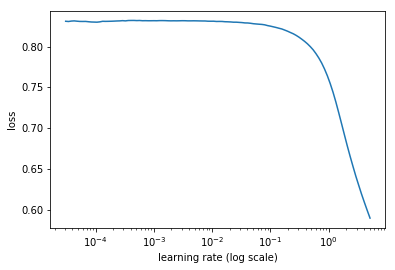

In [25]:
lfr = learn.lr_find()
learn.sched.plot()

In [26]:
learn.fit(3., 6)

epoch      trn_loss   val_loss   f1                           
    0      0.099599   0.078169   0.408124  
    1      0.080777   0.075574   0.421888                     
    2      0.077062   0.074879   0.426318                     
    3      0.076109   0.074644   0.426387                     
    4      0.074503   0.073504   0.440056                     
    5      0.073583   0.073461   0.440184                     



[0.073461205, 0.4401836326669822]

In [27]:
tta = learn.TTA()

In [28]:
multi_preds, y = tta

In [29]:
preds = np.mean(multi_preds, axis=0)

In [30]:
preds.shape

(1964, 221)

In [31]:
f1(preds, y)

0.43399406409158575

In [32]:
y[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
preds[:10]

array([[0.00047, 0.01148, 0.00169, ..., 0.03262, 0.00319, 0.00503],
       [0.00025, 0.00611, 0.00091, ..., 0.02137, 0.00112, 0.00282],
       [0.00047, 0.0165 , 0.00046, ..., 0.01705, 0.00069, 0.00356],
       ...,
       [0.00035, 0.00852, 0.00076, ..., 0.01076, 0.0011 , 0.01339],
       [0.00065, 0.01045, 0.00071, ..., 0.01792, 0.00112, 0.00351],
       [0.00031, 0.02285, 0.00065, ..., 0.01221, 0.00269, 0.00247]], dtype=float32)

In [34]:
# Download test images

In [35]:
test_json = json.load(open('./data/imaterialist/test.json'))

In [36]:
test_json.keys()

dict_keys(['images'])

In [37]:
len(test_json['images'])

39706

In [38]:
test_json['images'][0]

{'url': 'https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large',
 'imageId': 1}

In [121]:
for img in tqdm_notebook(test_json['images']):
    _download_image(img)

In [122]:
for f in os.listdir(f'{PATH}test'):
    try:
        Image.open(f'{PATH}test/{f}')
    except OSError as e:
        print(e)
        os.remove(f'{PATH}test/{f}')

In [123]:
data = ImageClassifierData.from_names_and_array(
    PATH, train_imgs, y_transformed, mlb.classes_, tfms=tfms_from_model(arch, sz), test_name='test')

In [124]:
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)

In [135]:
learn.fit(3., 10)

epoch      trn_loss   val_loss   f1                           
    0      0.099455   0.077659   0.414763  
    1      0.080226   0.075218   0.424443                     
    2      0.076593   0.074815   0.422574                     
    3      0.074618   0.073936   0.435682                     
    4      0.073531   0.073341   0.439719                     
    5      0.073507   0.073337   0.433324                     
    6      0.072846   0.073067   0.440876                     
    7      0.071863   0.073132   0.432091                     
    8      0.071796   0.073122   0.437281                     
    9      0.070903   0.073086   0.439525                     



[0.07308561, 0.4395249992285097]

In [136]:
learn.data.test_dl

In [137]:
log_preds, targs = learn.TTA()

In [139]:
f1(np.mean(log_preds, axis=0), targs)

0.43332945625176983

In [140]:
log_preds, _ = learn.TTA(is_test=True)

In [141]:
np.mean(log_preds, axis=0).shape

(39462, 221)

In [142]:
len(test_json['images'])

39706